# Dynamic dependence network forecasts

Replicating Zhao et al (2016) _Dynamic Dependence Networks: Financial Time Series Forecasting & Portfolio Decisions_.

## Abstract from Zhao et al (2016)

We discuss Bayesian forecasting of increasingly high-dimensional time series, a key area of application of
stochastic dynamic models in the financial industry and allied areas of business. Novel state-space models
characterizing sparse patterns of dependence among multiple time series extend existing multivariate
volatility models to enable scaling to higher numbers of individual time series. The theory of these dynamic
dependence network models shows how the individual series can be decoupled for sequential analysis, and
then recoupled for applied forecasting and decision analysis. Decoupling allows fast, efficient analysis of
each of the series in individual univariate models that are linked– for later recoupling– through a theoretical
multivariate volatility structure defined by a sparse underlying graphical model. Computational
advances are especially significant in connection with model uncertainty about the sparsity patterns among
series that define this graphical model; Bayesian model averaging using discounting of historical information
builds substantially on this computational advance. An extensive, detailed case study showcases the
use of these models, and the improvements in forecasting and financial portfolio investment decisions that
are achievable. Using a long series of daily international currency, stock indices and commodity prices,
the case study includes evaluations of multi-day forecasts and Bayesian portfolio analysis with a variety of
practical utility functions, as well as comparisons against commodity trading advisor benchmarks.

# Data

We analyze m = 13 financial time series with yt being logged values of daily closing prices of 9 currency
exchange rates relative to the US dollar, 2 commodities prices, and 2 U.S. stock indices; see Table 1. The
time period of 2,979 working-week days from August 1st 2000 to December 31st 2011 includes periods of
major growth as well as recession in the US and worldwide economies. The series represent major liquid
benchmark securities across 3 asset classes to approximately reflect the global macroeconomic conditions.
We model log prices directly, building on our experience that this is a surer route to useful predictive
models than the traditional approach using returns [e.g. 10]; the basic point here is that moving to returns
can “difference away” small changes in time that can be important in influencing short-term predictions if
allowed via models on prices (or log prices) that have some opportunity to capture them. We split the data
into a training and test data period: from August 1st 2000 to April 14th 2006 (1,489 observations) as the
training data set, and then from April 17th 2006 to December 31st 2011 (1,490 log-prices) as the test date
set to evaluate step ahead forecasting and portfolio outcomes.

In [7]:
#%pip install pymc3
#%pip install --upgrade pymc pytensor

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [13]:
# simulate data, each series is log-normally distributed
m = 13
days = 2_979
days = 10
np.random.seed(0)
data = np.exp(np.random.randn(days, m))
df = pd.DataFrame(data, columns=[f'series_{i}' for i in range(m)])
df['date'] = pd.date_range('2000-01-01', periods=days)
df = df.set_index('date')
print(df.shape)
df

(10, 13)


,series_0,series_1,series_2,series_3,series_4,series_5,series_6,series_7,series_8,series_9,series_10,series_11,series_12
date,,,,,,,,,,,,,
2000-01-01,5.836039,1.492059,2.661096,9.401725,6.472471,0.376334,2.585938,0.859541,0.901930,1.507720,1.154934,4.281372,2.140496
2000-01-02,1.129387,1.558717,1.396088,4.455232,0.814518,1.367614,0.425668,0.077849,1.922485,2.373667,0.476082,9.677026,0.233548
2000-01-03,1.046822,0.829291,4.631030,4.346447,1.167597,1.459600,0.411566,0.137959,0.706161,1.169234,3.422224,3.328028,0.678869
2000-01-04,0.739114,0.350444,0.241710,0.181542,7.034140,0.600704,0.645278,0.285705,2.176004,0.199110,0.808366,0.408417,1.472413
2000-01-05,0.600012,0.307085,0.972211,1.534695,1.068779,1.353200,0.530295,0.695766,0.510451,0.697988,0.443461,0.177945,1.194140
2000-01-06,0.669127,0.195891,1.588487,0.403613,1.053318,2.073194,1.137671,3.124895,0.290885,1.495322,0.504186,0.418618,0.560543
2000-01-07,0.732309,1.057773,0.311876,2.461637,1.593069,0.215188,4.429347,6.658466,3.250405,0.835333,0.342750,2.870401,0.668194
2000-01-08,3.395480,1.231552,2.655516,1.428131,2.027033,1.010555,5.964770,1.135317,1.494795,6.574186,0.259822,0.280695,2.636353
2000-01-09,0.309399,6.983996,0.661253,0.473570,6.841055,4.395208,6.472478,2.474516,0.422644,6.753527,0.764905,2.231014,2.578614


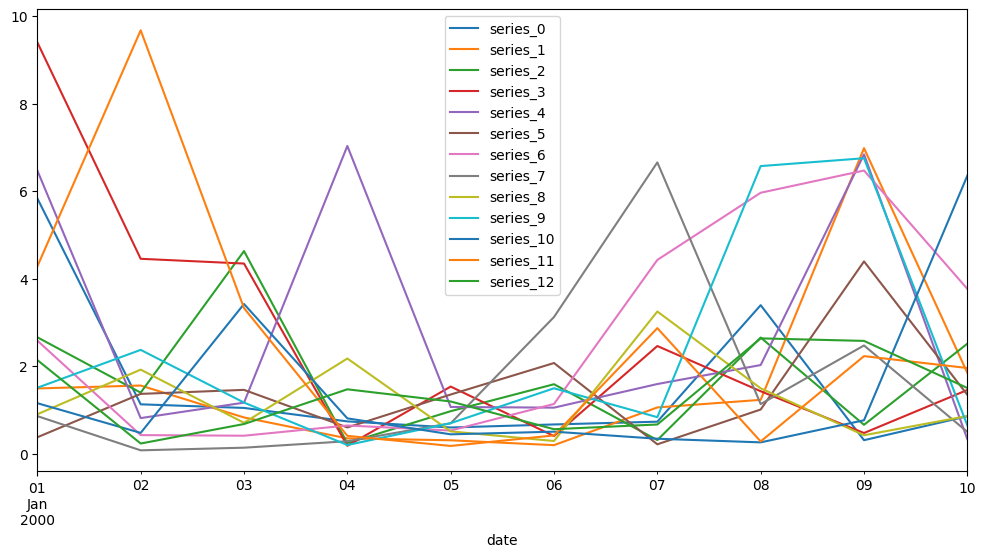

In [14]:
# plot series on one plot
df.plot(figsize=(12, 6))
plt.show()

In [15]:
# define the dynamic dependence network
def dynamic_dependence_network_model(data, lags=1):
    n, m = data.shape
    with pm.Model() as model:
        c = pm.Normal('c', mu=0, sigma=1, shape=(m,))
        phi = pm.Normal('phi', mu=0, sigma=1, shape=(lags, m))
        gamma = pm.Normal('gamma', mu=0, sigma=1, shape=(m, m))
        sigma = pm.HalfNormal('sigma', sigma=1, shape=(m,))

        y_t = []
        for t in range(lags, len(data)):
            mu_t = c.copy()
            for lag in range(1, lags+1):
                mu_t += phi[lag-1] * data.shift(lag).iloc[t]
            mu_t += pm.math.dot(data.iloc[t], gamma)
            y_t.append(pm.Normal('y_t_{}'.format(t), mu=mu_t, sigma=sigma, observed=data.iloc[t]))
        trace = pm.sample(1000, tune=1000, return_inferencedata=True)
    return model, trace

model, trace = dynamic_dependence_network_model(df)

c:\Users\regin\.conda\envs\d2lai\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\regin\.conda\envs\d2lai\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
c:\Users\regin\.conda\envs\d2lai\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
c:\Users\regin\.conda\envs\d2lai\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
c:\Users\regin\.conda\envs\d2lai\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fus

Output()

In [ ]:
pm.traceplot(trace)
plt.show()

In [ ]:
def forecast_ddnm(model, trace, data, steps=10, lags=1):
    with model:
        pm.set_data({'y': data.values})
        posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['y'], samples=steps)
    
    forecasts = posterior_predictive['y'].mean(axis=0)
    return forecasts

# Forecast the next 10 steps
forecasts = forecast_ddnm(model, trace, data, steps=10)
print(forecasts)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have true future values to compare with
true_values = np.array([actual_future_values])  # Replace with actual future values
rmse = mean_squared_error(true_values, forecasts, squared=False)
mae = mean_absolute_error(true_values, forecasts)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
